In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from math import gcd

In [34]:
"""
global variables

theta dir : num//4 pixels
phi dir : num pixels
2*pi/num per pixel
"""

PI = 3.14159265358979
wave_length = 1.0
k = 2*PI / wave_length
n_ = 120*PI
num = 64
r = 10 * wave_length
EPS = 1e-3

In [3]:
"""
size of unit cell < wavelength / 2
"""
c = wave_length / 4


In [8]:
"""
nx, ny : number of cells in x, y direction
theta0, phi0 : steering angle in 3d coordinates

assume uniform E field for each unit cell surface
assume beta_x = k*c*sin(theta0)*cos(phi0) & beta_y = k*c*sin(theta0)*sin(phi0)
"""


class MetaSurface():
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        
    def get_array_factor(self, theta0, phi0):
        array_factor = np.zeros((num//4, num), dtype=np.complex128)
        xid = np.arange(0, self.nx, 1)
        yid = np.arange(0, self.ny, 1)
        px = np.sin(theta0)*np.cos(phi0)
        py = np.sin(theta0)*np.sin(phi0)
        
        #row : theta, col : phi
        for i in range(num//4):
            for j in range(num):
                theta = 2*PI/num*i
                phi = 2*PI/num*j
                x_expon = np.exp(1j*k*c*(np.sin(theta)*np.cos(phi) - px)*xid)
                y_expon = np.exp(1j*k*c*(np.sin(theta)*np.sin(phi) - py)*yid)
                array_factor[i, j] = np.sum(x_expon * np.vstack(y_expon))
        self.array_factor = array_factor
        return array_factor
    
    def get_dir(self, theta0, phi0):
        theta = np.linspace(0, PI/2, num//4)
        sin_theta = np.vstack(np.sin(theta))
        
        array_factor = self.get_array_factor(theta0, phi0)
        u = np.real(array_factor*np.conj(array_factor))
        pr = 1/(4*PI)*np.sum(u*sin_theta*(4*PI*PI/(num**2))) 
        self.dir = 10*np.log10(u/pr)
        self.dir[self.dir<0] = 0
    
    """------------------  from here call after calling get_dir ------------------------"""
    
    def rotate2origin(self):
        i, j = np.unravel_index(np.argmax(self.dir, axis=None), self.dir.shape)
        dir_ = np.roll(self.dir, -j, axis=1)
        dir_ = np.roll(dir_, -i, axis=0)
        return dir_
    
    def get_maxdir(self):
        return np.max(self.dir)
    
    def get_hpbw(self):
        i, j = np.unravel_index(np.argmax(self.dir, axis=None), self.dir.shape)
        dmax = np.max(self.dir)
        hd = dmax - 3
        dir_ = np.abs(self.dir - hd)
        ti = np.argmin(dir_[:,j])
        pi = np.argmin(dir_[i,:])
        return (abs(ti - i)*2*2*PI/num, abs(pi-j)*2*2*PI/num)
    
    def plot_dir(self, theta0, phi0):
        d = self.dir
        theta = np.linspace(0, PI/2, num//4)
        phi = np.linspace(0, PI*2, num)
        phi_, theta_ = np.meshgrid(phi, theta)
        x = d * np.vstack(np.sin(theta_)) * np.cos(phi_)
        y = d * np.vstack(np.sin(theta_)) * np.sin(phi_)
        z = d * np.vstack(np.cos(theta_))
        
        dmax = np.max(d)
        print(dmax)
        i, j = np.unravel_index(np.argmax(d, axis=None), d.shape)
        print(i)
        print(j)
        
        ax = plt.axes(projection='3d')
        ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
        ax.set_title('surface');
        ax.set_xlim([-35, 35])
        ax.set_ylim([-35, 35])
        ax.set_zlim(bottom = 0.0)

In [91]:
theta0 = 0.0
phi0 = 0.0
nx = 12
ny = 12

In [92]:
msurf_test = MetaSurface(nx, ny)

In [93]:
msurf_test.get_dir(theta0, phi0)

20.436901162058724
0
0


<IPython.core.display.Javascript object>


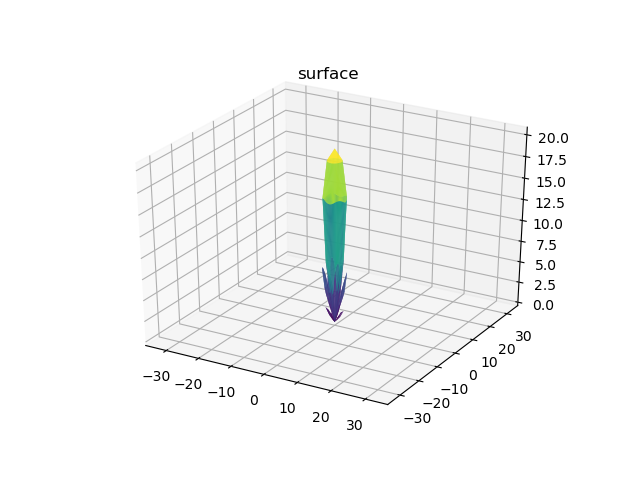

In [94]:
msurf_test.plot_dir(theta0, phi0)

In [95]:
theta_h, phi_h = msurf_test.get_hpbw()
dmax = msurf_test.get_maxdir()

In [96]:
print(theta_h)
print(phi_h)
print(dmax)

0.19634954084936188
0.0
20.436901162058724


### given theta0, phi0, dmax, theta_h, phi_h 
### find nx & ny that fits best

In [100]:
"""
given : theta0, phi0, dmax, theta_h, phi_h, c(unit cell size)
return : nx, ny that produces beam that fits best

time complexity O(nx log(ny) * num^2 * nx * ny)
"""

def find_metasurface(input):
    theta0 = input[0]
    phi0 = input[1]
    dmax = input[2]
    theta_h = input[3]
    phi_h = input[4]
        
    nx_cand = np.arange(2, 21, 1)
    min_error = 1e9
    nx_rec = 0
    ny_rec = 0
    
    for nx_ in nx_cand: 
        lo = 2
        hi = 21
        ny_ = 2
        
        #binary search ny_ for fixed nx_
        while lo <= hi:
            mid = (lo + hi)//2
            tmp = MetaSurface(nx_, mid)
            tmp.get_dir(theta0, phi0)
            if tmp.get_maxdir() < dmax and abs(dmax-tmp.get_maxdir())>EPS:
                lo = mid + 1
                ny_ = mid
            elif tmp.get_maxdir() > dmax and abs(dmax-tmp.get_maxdir())>EPS:
                hi = mid - 1
                ny_ = mid
            else:
                ny_ = mid
                break
        cand = MetaSurface(nx_, ny_)
        cand.get_dir(theta0, phi0)
        theta_h_, phi_h_ = cand.get_hpbw()
        error = abs((theta_h - theta_h_)/(theta_h+EPS)) + abs((phi_h - phi_h_)/(phi_h+EPS))
        if error < min_error:
            min_error = error
            nx_rec = nx_
            ny_rec = ny_
    return (nx_rec, ny_rec)

In [101]:
nx_rec, ny_rec = find_metasurface([theta0, phi0, dmax, theta_h, phi_h])

In [102]:
print(nx_rec)
print(ny_rec)

12
12
